**Setup and Data Loading**

In [1]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
from google.colab import drive
from huggingface_hub import notebook_login
# NEW: Added AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DistilBertModel
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

RNG = 42

# --- MOUNTING GOOGLE DRIVE & LOGGING IN ---
drive.mount('/content/drive')
notebook_login()

# --- LOADING THE DATASET ---
FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/55k data 3 class Movie review.csv'
df = pd.read_csv(FILE_PATH)

# quick sanity
# MODIFIED: Added '3 class label' to the check
needed_cols = [
    'title', 'reviewText', 'audienceScore', 'tomatoMeter', 'runtimeMinutes',
    'genre', 'language_encoded', 'director_encoded',
    'sentiment_label', '3 class label' # <-- Ensured our new target column is checked
]
missing = [c for c in needed_cols if c not in df.columns]
assert not missing, f"Missing columns in CSV: {missing}"

# Also adding a specific check for our key columns
assert 'reviewText' in df.columns, "Data is missing the 'reviewText' column."
assert '3 class label' in df.columns, "Data is missing the '3 class label' column."

print("--- Part 1: Setup and Data Loading Complete ---")
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"Columns: {df.columns.tolist()}")

Mounted at /content/drive


--- Part 1: Setup and Data Loading Complete ---
Dataset loaded with 165276 rows and 10 columns.
Columns: ['title', 'reviewText', 'audienceScore', 'tomatoMeter', 'runtimeMinutes', 'genre', 'language_encoded', 'director_encoded', 'sentiment_label', '3 class label']


**Feature Preprocessing**

In [3]:
# --- CLEAN MINIMUMS ---
# MODIFIED: Dropna based on our new target '3 class label'
df = df.dropna(subset=['reviewText', '3 class label']).copy()
# MODIFIED: Assign the 'label' column from our new target '3 class label'
df['label'] = df['3 class label'].astype(int)

# MODIFIED: Class names for 3-class report (assuming 0=Neg, 1=Neu, 2=Pos)
class_names = ['Negative', 'Neutral', 'Positive']
N_CLASSES = len(class_names)
assert N_CLASSES == 3, "Class names must match 3 classes"
print(f"Target classes: {class_names}")

# Text fields (No changes needed)
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")
df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

# --- STRATIFIED SPLIT ---
# (No changes needed here, as it correctly uses df['label'], which we just fixed)
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

y_train = train_df['label'].values.astype(int)
y_test  = test_df['label'].values.astype(int)

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
print(f"Train label distribution:\n{train_df['label'].value_counts(normalize=True).sort_index()}")

# ============ FIT PREPROCESSORS ON TRAIN ONLY ============

# --- Numeric: fill NA with train medians, then scale ---
# (No changes needed)
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
train_numeric = train_df[NUMERIC_COLS].copy()
train_medians = train_numeric.median(numeric_only=True)
train_numeric = train_numeric.fillna(train_medians)

scaler = StandardScaler()
scaler.fit(train_numeric.values)  # fit on train only

# --- Categorical: genre (multi-label) ---
# (No changes needed)
train_genre_list = train_df['genre'].fillna("Unknown").str.split(', ')
mlb = MultiLabelBinarizer()
mlb.fit(train_genre_list)

# --- language_encoded: One-Hot (small cardinality) ---
# (No changes needed)
import sklearn
from packaging import version

train_lang = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
else:
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)

ohe_lang.fit(train_lang.to_frame())


# --- director_encoded: Frequency + K-fold target mean (leak-safe) ---
#
# MODIFIED: This function is completely rewritten for 3-class target encoding.
#
def director_features_multiclass(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits: int = 5):
    """
    Leak-safe target encoding for MULTI-CLASS with a frequency feature.
    Encodes target as a probability distribution [P(c=0), P(c=1), P(c=2)].
    """
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # --- 1. Frequency (log1p) using TRAIN counts only ---
    freq = s_train.value_counts()
    tr_freq = s_train.map(freq).fillna(0).astype(float).values
    te_freq = s_test.map(freq).fillna(0).astype(float).values
    tr_freq = np.log1p(tr_freq)[:, None].astype(np.float32) # shape (N, 1)
    te_freq = np.log1p(te_freq)[:, None].astype(np.float32) # shape (M, 1)

    # --- 2. K-fold target mean (leak-safe) ---

    # One-Hot Encode the target 'y'
    n_classes = len(np.unique(y))
    y_ohe = OneHotEncoder(
        categories=[range(n_classes)], # Ensure it respects 0, 1, 2
        sparse_output=False,
        dtype=np.float32
    ).fit_transform(y.reshape(-1, 1)) # shape (N, 3)

    # Global prior (mean probability for each class)
    global_mean = y_ohe.mean(axis=0) # shape (3,)

    # Output arrays
    tr_te = np.zeros((len(s_train), n_classes), dtype=np.float32) # shape (N, 3)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    # Use y (1D) for splitting
    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_part_directors = s_train.iloc[tr_i]

        # Calculate means on the fold's training data
        fold_means_df = pd.DataFrame(
            y_ohe[tr_i], index=tr_part_directors.index
        ).groupby(tr_part_directors).mean()

        # Map these means to the validation part
        val_part_directors = s_train.iloc[val_i]

        # === [BUG FIX] ===
        # The old .join(on=Series) logic was incorrect and created object arrays.
        # This new .merge() logic is robust and correct.

        # 1. Convert the director Series (which has the correct index) to a DataFrame
        val_df = val_part_directors.to_frame(name='director_id')

        # 2. Merge using the director_id column, joining on the index of fold_means_df
        merged_val_df = val_df.merge(
            fold_means_df, left_on='director_id', right_index=True, how='left'
        )

        # 3. Get the float values, dropping the 'director_id' helper column
        val_means = merged_val_df.drop('director_id', axis=1).values
        # === [END FIX] ===

        # Fill in missing directors (those not in fold_means_df) with global prior
        missing_mask = np.isnan(val_means.sum(axis=1))
        val_means[missing_mask] = global_mean

        tr_te[val_i] = val_means.astype(np.float32)

    # --- 3. Test target mean: compute means on FULL train, then map ---
    full_means_df = pd.DataFrame(
        y_ohe, index=s_train.index
    ).groupby(s_train).mean()

    # Map full training means to the test set

    # === [BUG FIX] ===
    # Apply the same merge logic to the test set
    test_s_df = s_test.to_frame(name='director_id')
    merged_test_df = test_s_df.merge(
        full_means_df, left_on='director_id', right_index=True, how='left'
    )
    te_te = merged_test_df.drop('director_id', axis=1).values
    # === [END FIX] ===

    # Fill in missing directors (those not in full_means_df) with global prior
    missing_mask_test = np.isnan(te_te.sum(axis=1))
    te_te[missing_mask_test] = global_mean

    te_te = te_te.astype(np.float32) # shape (M, 3)

    return tr_freq, te_freq, tr_te, te_te

# --- Apply the new function ---
if 'director' in train_df.columns:
    dtr_f, dte_f, dtr_te, dte_te = director_features_multiclass(
        train_df['director'], y_train, test_df['director']
    )
else:
    dtr_f, dte_f, dtr_te, dte_te = director_features_multiclass(
        train_df['director_encoded'].astype(str), y_train,
        test_df['director_encoded'].astype(str)
    )

# Final director block = [freq (1 col), target_mean (3 cols)]
# (No changes needed, concatenate handles the new shape)
dir_train_block = np.concatenate([dtr_f, dtr_te], axis=1).astype(np.float32)
dir_test_block  = np.concatenate([dte_f, dte_te], axis=1).astype(np.float32)

print("--- Part 2: Preprocessing Complete ---")
print(f"Shape of director features for train: {dir_train_block.shape}")
print(f"Shape of director features for test:  {dir_test_block.shape}")

Target classes: ['Negative', 'Neutral', 'Positive']
Train shape: (132220, 12), Test shape: (33056, 12)
Train label distribution:
label
0    0.333338
1    0.333331
2    0.333331
Name: proportion, dtype: float64
--- Part 2: Preprocessing Complete ---
Shape of director features for train: (132220, 4)
Shape of director features for test:  (33056, 4)


**Dataset Preparation and Tokenization**

In [4]:
def build_features(split_df: pd.DataFrame, dir_block: np.ndarray):
    """Combines all processed features into a dictionary."""
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()

    # numeric → fill with TRAIN medians, then TRAIN scaler
    numeric = split_df[NUMERIC_COLS].copy().fillna(train_medians)
    numeric_scaled = scaler.transform(numeric.values).astype(np.float32)   # (N, 3)
    out['numerical_features'] = [row for row in numeric_scaled]

    # genre multi-hot via TRAIN-fitted mlb
    genre_list = split_df['genre'].fillna("Unknown").str.split(', ')
    genre_bin = mlb.transform(genre_list).astype(np.float32)               # (N, G)

    # language one-hot via TRAIN-fitted OHE
    lang = split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
    lang_ohe = ohe_lang.transform(lang.to_frame()).astype(np.float32)       # (N, L)

    # director (provided precomputed leak-safe block)
    # MODIFIED: Note shape is (N, 4) for 3-class, not (N, 2)
    cat = np.concatenate([genre_bin, lang_ohe, dir_block], axis=1).astype(np.float32)
    out['categorical_features'] = [row for row in cat]
    return out

print("Building feature dictionaries...")
train_feats = build_features(train_df, dir_train_block)
test_feats  = build_features(test_df,  dir_test_block)
print("Done.")

# --- Sizes for the classifier head ---
num_numerical_features = len(NUMERIC_COLS) # Should be 3
num_genre = len(mlb.classes_)
num_lang  = ohe_lang.get_feature_names_out().shape[0]

# MODIFIED: This is the key change.
# The binary code had 2 (freq + mean).
# Our 3-class code has 4 (freq + prob_c0 + prob_c1 + prob_c2).
num_dir_enc = dir_train_block.shape[1] # This will be 4
num_categorical_features = num_genre + num_lang + num_dir_enc

print("--- Feature Dimensions ---")
print(f"Numeric features:   {num_numerical_features}")
print(f"Genre features:     {num_genre}")
print(f"Language features:  {num_lang}")
print(f"Director features:  {num_dir_enc}  <-- (1 freq + {N_CLASSES} target encodings)")
print(f"TOTAL Categorical:  {num_categorical_features}")


# --- Wrap into DataFrames for HF ---
final_train_df = pd.DataFrame({
    'combined_text': train_feats['combined_text'],
    'label': train_feats['label'],
    'numerical_features': train_feats['numerical_features'],
    'categorical_features': train_feats['categorical_features'],
})
final_test_df = pd.DataFrame({
    'combined_text': test_feats['combined_text'],
    'label': test_feats['label'],
    'numerical_features': test_feats['numerical_features'],
    'categorical_features': test_feats['categorical_features'],
})

# --- HF Dataset ---
raw_multimodal_datasets = DatasetDict({
    'train': Dataset.from_pandas(final_train_df),
    'test':  Dataset.from_pandas(final_test_df),
})

# --- TOKENIZATION ---
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_multimodal_function(examples):
    # Tokenizes the text. This is the same for binary and 3-class.
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

print("\nTokenizing datasets...")
tokenized_multimodal_datasets = raw_multimodal_datasets.map(tokenize_multimodal_function, batched=True)

# Clean up columns
cols_to_remove = [c for c in ["combined_text", "__index_level_0__"] if c in tokenized_multimodal_datasets["train"].column_names]
tokenized_multimodal_datasets = tokenized_multimodal_datasets.remove_columns(cols_to_remove)
tokenized_multimodal_datasets.set_format("torch")

print("--- Part 3: Dataset Creation Complete ---")
print(tokenized_multimodal_datasets)

Building feature dictionaries...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['special interest'] will be ignored
  warnings.warn(


Done.
--- Feature Dimensions ---
Numeric features:   3
Genre features:     31
Language features:  14
Director features:  4  <-- (1 freq + 3 target encodings)
TOTAL Categorical:  49


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Tokenizing datasets...


Map:   0%|          | 0/132220 [00:00<?, ? examples/s]

Map:   0%|          | 0/33056 [00:00<?, ? examples/s]

--- Part 3: Dataset Creation Complete ---
DatasetDict({
    train: Dataset({
        features: ['label', 'numerical_features', 'categorical_features', 'input_ids', 'attention_mask'],
        num_rows: 132220
    })
    test: Dataset({
        features: ['label', 'numerical_features', 'categorical_features', 'input_ids', 'attention_mask'],
        num_rows: 33056
    })
})


**Training the Model**

In [5]:
# --- MODEL ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical_features, num_categorical_features):
        super(MultimodalClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        # This linear layer is correctly parameterized by num_labels
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + num_numerical_features + num_categorical_features,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_output = distilbert_output.last_hidden_state[:, 0]  # (B, H)
        pooled_output = self.dropout(cls_token_output)

        # numerical_features: (B, 3); categorical_features: (B, K)
        combined_features = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined_features)

        loss = None
        if labels is not None:
            # CrossEntropyLoss works for binary (1D logits, 1D labels) and
            # multi-class (ND logits, 1D labels) automatically.
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, logits) if loss is not None else (None, logits)

# --- DATA COLLATOR ---
# (No changes needed in the class itself)
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        numerical_features = np.stack([np.array(f['numerical_features'], dtype=np.float32) for f in features])
        categorical_features = np.stack([np.array(f['categorical_features'], dtype=np.float32) for f in features])

        # 'labels' are dtype=torch.long, which is correct for CrossEntropyLoss
        batch['labels'] = torch.tensor([int(f['label']) for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.tensor(numerical_features, dtype=torch.float32)
        batch['categorical_features'] = torch.tensor(categorical_features, dtype=torch.float32)
        return batch

# --- INIT MODEL & COLLATOR ---
#
# MODIFIED: Changed num_labels from 2 to N_CLASSES (which is 3)
#
multimodal_model = MultimodalClassifier(
    num_labels=N_CLASSES, # <-- CRITICAL CHANGE
    num_numerical_features=num_numerical_features,
    num_categorical_features=num_categorical_features
)
data_collator = MultimodalDataCollator(tokenizer)

# --- METRICS ---
#
# MODIFIED: Changed average='binary' to average='macro'
#
def compute_metrics(pred):
    labels = pred.label_ids
    # pred.predictions[0] is the logits
    preds = pred.predictions[0].argmax(-1) if isinstance(pred.predictions, tuple) else pred.predictions.argmax(-1)

    # 'macro' computes metrics for each class, then takes the unweighted average.
    # 'weighted' would account for class imbalance, but our classes are balanced.
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro' # <-- CRITICAL CHANGE
    )
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# --- TRAINING ARGS ---
#
# MODIFIED: Updated output_dir name
#
multimodal_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/THESIS 47/Saved Datasets/results_3_CLASS_multimodal_ALL_FEATURES_DIRTE", # <-- MODIFIED
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50,
    report_to="none"
)

# --- TRAINER ---
multimodal_trainer = Trainer(
    model=multimodal_model,
    args=multimodal_training_args,
    train_dataset=tokenized_multimodal_datasets["train"],
    eval_dataset=tokenized_multimodal_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# --- TRAIN ---
#
# MODIFIED: Updated print statement
#
print("\n--- Starting Training for Multimodal 3-CLASS Model (ALL FEATURES + Director TargetEnc) ---")
multimodal_trainer.train()

print("\n--- Training Complete ---")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



--- Starting Training for Multimodal 3-CLASS Model (ALL FEATURES + Director TargetEnc) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.742700,0.699925,0.668048,0.650794,0.656001,0.668052
2,0.603500,0.704548,0.677668,0.671587,0.670742,0.677672
3,0.430100,0.788159,0.671194,0.669524,0.668431,0.671196



--- Training Complete ---


**Enhanced Evaluation for  Binary Model**

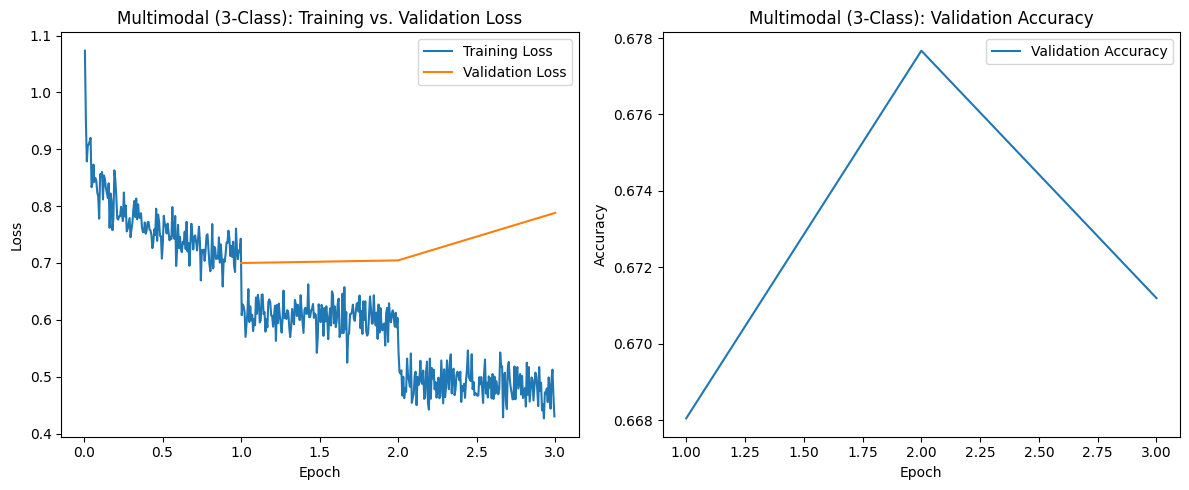


--- Final Evaluation on Test Set (3-Class Multimodal) ---


{'eval_loss': 0.6999245882034302, 'eval_accuracy': 0.668048160696999, 'eval_f1': 0.6507935620649808, 'eval_precision': 0.6560005588903315, 'eval_recall': 0.668052230866455, 'eval_runtime': 230.6277, 'eval_samples_per_second': 143.331, 'eval_steps_per_second': 8.958, 'epoch': 3.0}
Logits shape: (33056, 3)

--- Classification Report (3-Class Multimodal) ---
              precision    recall  f1-score   support

    Negative       0.68      0.80      0.73     11018
     Neutral       0.59      0.38      0.46     11019
    Positive       0.70      0.83      0.76     11019

    accuracy                           0.67     33056
   macro avg       0.66      0.67      0.65     33056
weighted avg       0.66      0.67      0.65     33056



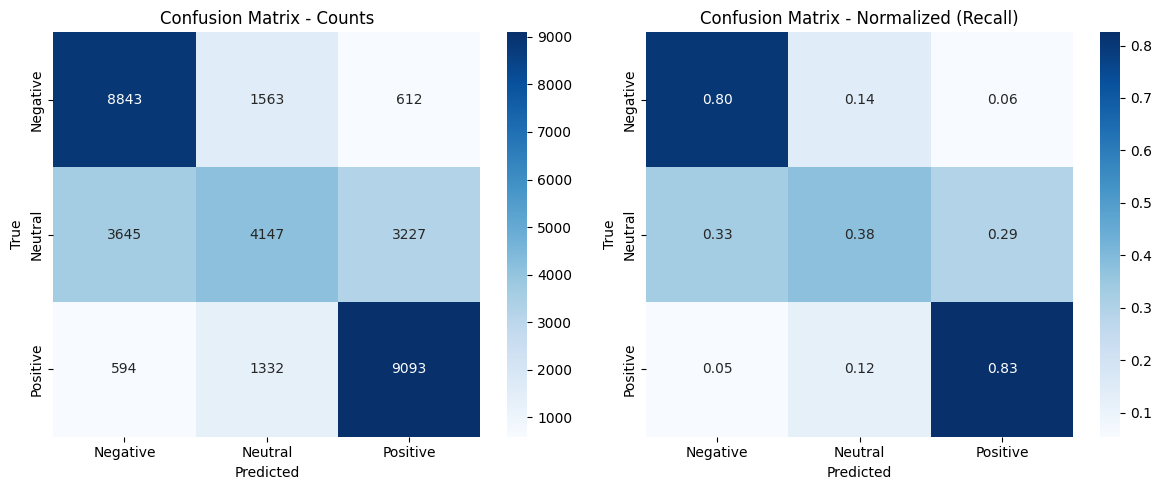

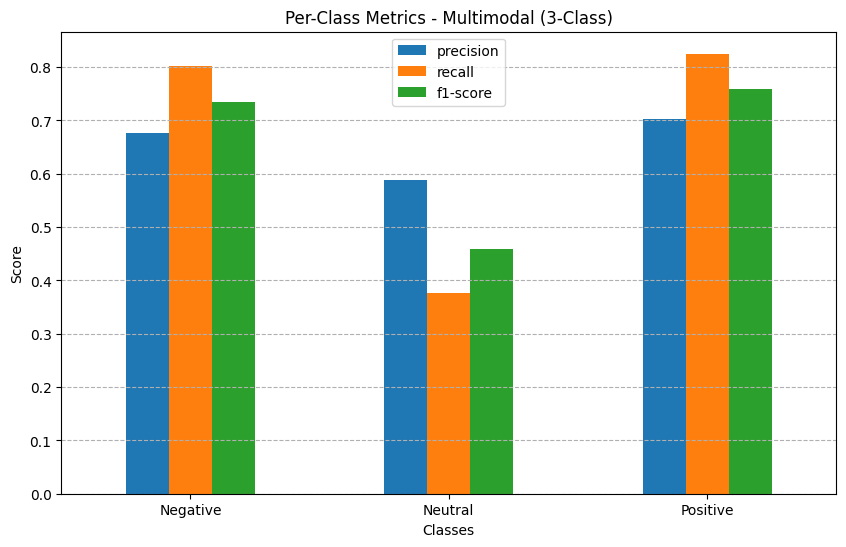


Multimodal (3-Class) model saved to: /content/drive/MyDrive/THESIS 47/Saved Datasets/[3_Class]fine-tuned_multimodal_ALL_FEATURES_DIRTE
First 10 preds vs true: [(np.int64(2), np.int64(2)), (np.int64(2), np.int64(0)), (np.int64(0), np.int64(1)), (np.int64(2), np.int64(1)), (np.int64(1), np.int64(1)), (np.int64(1), np.int64(1)), (np.int64(2), np.int64(1)), (np.int64(0), np.int64(1)), (np.int64(0), np.int64(0)), (np.int64(2), np.int64(1))]


In [6]:
# ==========================
# EVALUATE • REPORT • PLOTS • SAVE (Multimodal)
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# This 'try/except' block is robust and needs no changes.
# It will correctly find our 3-class 'class_names' list.
try:
    class_names
except NameError:
    num_labels = getattr(multimodal_trainer.model.config, "num_labels", None)
    if num_labels is None:
        uniq = sorted(set(tokenized_multimodal_datasets["test"]["label"]))
        num_labels = len(uniq)
    class_names = [f"Class {i}" for i in range(num_labels)]
    print(f"[Info] 'class_names' not found; using defaults: {class_names}")

# --- Curves ---
log_history = multimodal_trainer.state.log_history
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)],
         [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
         [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Multimodal (3-Class): Training vs. Validation Loss'); plt.legend()

plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
             [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Multimodal (3-Class): Validation Accuracy'); plt.legend()
else:
    plt.text(0.5, 0.5, 'No eval accuracy logged', ha='center', va='center')
    plt.axis('off')
plt.tight_layout(); plt.show()

# --- Final Eval ---
# MODIFIED: Updated print statement
print("\n--- Final Evaluation on Test Set (3-Class Multimodal) ---")
multimodal_eval_results = multimodal_trainer.evaluate()
print(multimodal_eval_results)

pred_out = multimodal_trainer.predict(tokenized_multimodal_datasets["test"])
logits = pred_out.predictions[0] if isinstance(pred_out.predictions, (list, tuple)) else pred_out.predictions
logits = np.asarray(logits)
print("Logits shape:", logits.shape) # Will be (N, 3)

# logits -> labels
# This logic is already perfect. For 3 classes, ndim will be 2,
# and np.argmax is the correct operation.
if logits.ndim == 2:
    multimodal_predicted_labels = np.argmax(logits, axis=-1)
    num_classes = logits.shape[1]
elif logits.ndim == 1:
    multimodal_predicted_labels = (logits > 0).astype(int)
    num_classes = 2
else:
    raise ValueError(f"Unexpected logits ndim: {logits.ndim}")

# This check is also robust and needs no changes
if len(class_names) != num_classes:
    print(f"[Warn] Adjusting class_names from {len(class_names)} to {num_classes}.")
    class_names = [f"Class {i}" for i in range(num_classes)]

true_labels = np.asarray(tokenized_multimodal_datasets["test"]["label"]).astype(int)

# --- Report ---
# MODIFIED: Updated print statement
print("\n--- Classification Report (3-Class Multimodal) ---")
# This will now correctly use our 3-class list
report_text = classification_report(true_labels, multimodal_predicted_labels,
                                      target_names=class_names, zero_division=0)
print(report_text)

report = classification_report(true_labels, multimodal_predicted_labels,
                                 target_names=class_names, output_dict=True, zero_division=0)

# --- Confusion Matrices ---
# This will correctly create a 3x3 matrix
cm = confusion_matrix(true_labels, multimodal_predicted_labels, labels=list(range(num_classes)))
row_sums = cm.sum(axis=1, keepdims=True); row_sums[row_sums == 0] = 1
cm_norm = cm.astype('float') / row_sums

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - Counts')

plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - Normalized (Recall)')
plt.tight_layout(); plt.show()

# --- Per-class bar chart ---
# This will now correctly show 3 groups of bars
report_df = pd.DataFrame(report).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]
ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
# MODIFIED: Updated title
plt.title('Per-Class Metrics - Multimodal (3-Class)')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend()
plt.show()

# --- SAVE MODEL ---
#
# MODIFIED: CRITICAL path change
#
output_multimodal_model_path = "/content/drive/MyDrive/THESIS 47/Saved Datasets/[3_Class]fine-tuned_multimodal_ALL_FEATURES_DIRTE"
multimodal_trainer.save_model(output_multimodal_model_path)
print(f"\nMultimodal (3-Class) model saved to: {output_multimodal_model_path}")

# --- QUICK PEEK ---
print("First 10 preds vs true:",
      list(zip(multimodal_predicted_labels[:10], true_labels[:10])))